In [3]:
import torch
from torchsummary import summary

import torchvision
import torchvision.transforms as transforms

from resnet import ResNet, BasicBlock
from pyramidnet import PyramidNet
import torch.nn as nn
import numpy as np

import matplotlib.pyplot as plt
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
gpu_number = torch.cuda.device_count()

In [4]:
# load test set
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=100, shuffle=False, num_workers=2)

Files already downloaded and verified


In [1]:
exp1 = './models/--batch_size 128 --net_type resnet --num_blocks 2,2,2,2 --optimizer adam --lr 0.01 --augmentation A.pth'
exp2 = './models/--batch_size 128 --net_type resnet --num_blocks 2,2,2,2 --optimizer sgd --lr 0.01 --augmentation A.pth'
exp3 = './models/--batch_size 128 --net_type resnet --num_blocks 2,2,2,2 --optimizer sgdm --lr 0.01 --augmentation A.pth'
exp4 = './models/--batch_size 128 --net_type resnet --num_blocks 2,2,2,2 --optimizer adam --lr 0.001 --augmentation A.pth'
exp5 = './models/--batch_size 128 --net_type resnet --num_blocks 2,2,2,2 --optimizer sgd --lr 0.001 --augmentation A.pth'
exp6 = './models/--batch_size 128 --net_type resnet --num_blocks 2,2,2,2 --optimizer sgdm --lr 0.001 --augmentation A.pth'
exp7 = './models/--batch_size 128 --net_type resnet --num_blocks 2,2,2,2 --optimizer adam --lr 0.0001 --augmentation A.pth'
exp8 = './models/--batch_size 128 --net_type resnet --num_blocks 2,2,2,2 --optimizer sgd --lr 0.0001 --augmentation A.pth'
exp9 = './models/--batch_size 128 --net_type resnet --num_blocks 2,2,2,2 --optimizer sgdm --lr 0.0001 --augmentation A.pth'

In [7]:
metrics = []
performance = []
for name in [exp1,exp2,exp3,exp4,exp5,exp6,exp7,exp8,exp9]:
    state = torch.load(name)
    metrics.append(state['metrics'])
    performance.append(state['acc'])

In [8]:
performance


[92.64, 91.61, 93.18, 93.36, 86.66, 91.44, 92.68, 71.01, 86.72]

In [29]:
# load best performing models
state = torch.load('./models/--batch_size 128 --net_type resnet --num_blocks 2,2,2,2 --optimizer sgdm --lr 0.001 --augmentation A.pth')

# Initialize resnet
resnet = ResNet(BasicBlock,[2,2,2,2]).to(device)
resnet.load_state_dict(state['net'])

<All keys matched successfully>

In [30]:
# Evaluate the model on the test set
correct = 0
total = 0
with torch.no_grad():
    for batch_idx, (inputs, targets) in enumerate(testloader):
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = resnet(inputs)
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
acc = 100.*correct/total
print('Accuracy:', acc,'%')

Accuracy: 89.08 %


In [31]:
for test_images, test_labels in testloader:  # Sample two images to predict their labels
    sample_images = test_images[:2].to(device)    
    sample_labels = test_labels[:2]

outputs = resnet(sample_images)
predictions = torch.argmax(outputs, axis=1)
print(f"Predicted labels: {predictions.cpu()} \nTrue labels: {sample_labels}")

Predicted labels: tensor([0, 3]) 
True labels: tensor([8, 3])


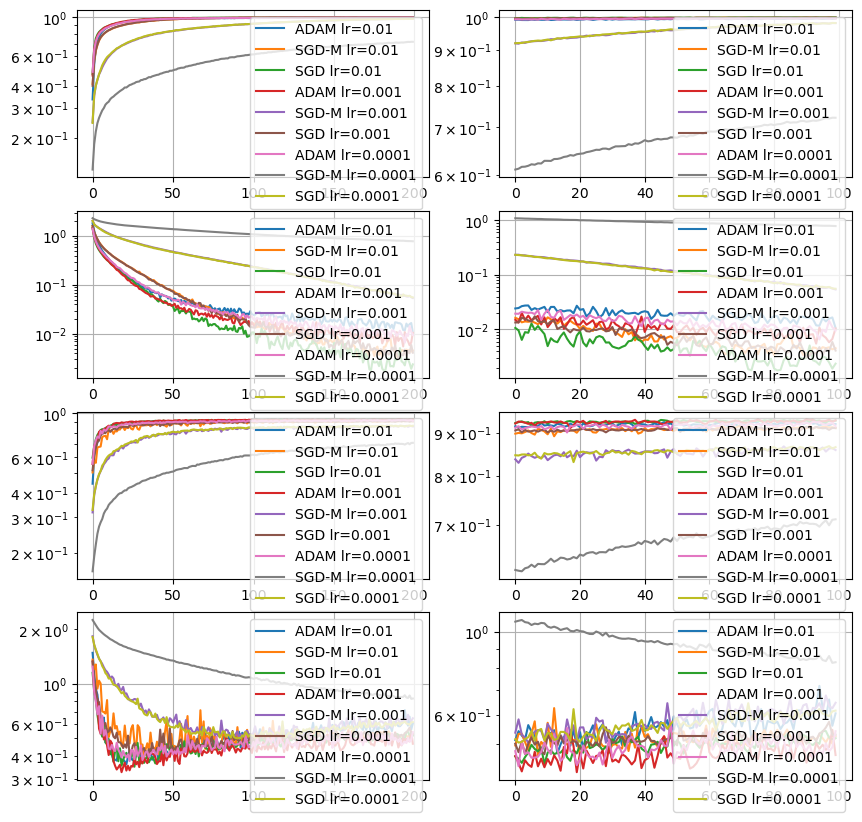

In [40]:
names = ['ADAM lr=0.01', "SGD-M lr=0.01", "SGD lr=0.01",'ADAM lr=0.001', "SGD-M lr=0.001", "SGD lr=0.001",'ADAM lr=0.0001', "SGD-M lr=0.0001", "SGD lr=0.0001"]
titles = ['train accuracy', 'test accuracy', 'train loss', 'test loss']
fig, ax = plt.subplots(4, 2, figsize=(10,10))

for i in range(4):
    for metric, name in zip(metrics, names):
        ax[i,0].plot(np.array(metric)[:,i], label = name)
        ax[i,1].plot(np.array(metric)[:,i][100:], label = name)
        ax[i,0].set_yscale('log')
        ax[i,0].grid()
        ax[i,1].set_yscale('log')
        ax[i,1].grid()
        #ax[i,0].legend()
        #ax[i,1].legend()

